In [ ]:
##Nice Work  kirtan
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('notebook', {'LimitOutput': 0})

{'LimitOutput': 0}

In [ ]:
##Nice Work  kirtan
import os
import cv2
from PIL import Image
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from math import ceil, sqrt
import natsort
import glob
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
##Nice Work  kirtan
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
##Nice Work  kirtan
frameDir_path = '/content/drive/MyDrive/Sign Language Project/CVM_HACKAHTON/Frames'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##Nice Work  kirtan
def load_json(path):
    with open(path, "r") as f:
        json_file = json.load(f)
    return json_file
label_map = load_json('/content/drive/MyDrive/Sign Language Project/CVM_HACKAHTON/label_map_lstm_include.json')
print(label_map)


{'loud': 0, 'quiet': 1, 'happy': 2}


In [34]:
##Nice Work  kirtan
labels_train = []
filenames_train = []
labels_test = []
filenames_test = []
labels_val = []
filenames_val = []
def get_Lables(mode):
    train_label = []
    train_filename = []
    train_split_file = f'/content/drive/MyDrive/Sign Language Project/CVM_HACKAHTON/train_test_split/lstm_include_{mode}.txt'
    train_file = open(train_split_file, 'r')
    for line in train_file:
        label = "".join([i for i in line if i.isalpha()]).lower()
        label = label[10:]
        label = label[:-6]
        line = line.split("/")
        line.pop(1)
        line.insert(1,label)
        last_word = line[-1].strip('\n')
        last_word = last_word + "_frames"
        line[-1] = last_word
        line = "/".join(line)
        line = frameDir_path +'/' + line #frame folder
        frame_names = os.listdir(line)
        for frame_name in frame_names:
            temp_fileName= os.path.join(line, frame_name)
            train_filename.append(temp_fileName)

    for frame in train_filename:
        split_frame = frame.split("/")
        train_label.append(split_frame[-3])
    for i in range(len(train_label)):
        train_label[i] = label_map[train_label[i]]
    train_file.close()
    return np.array(train_filename),np.array(train_label)

filenames_train,labels_train = get_Lables('train')
filenames_val,labels_val = get_Lables('val')
filenames_test,labels_test = get_Lables('test')
# print(filenames_train)
print(labels_train)

[1 1 1 ... 1 1 1]


In [ ]:
##Nice Work  kirtan
print(filenames_train.shape)
print(labels_train.shape)
print(filenames_test.shape)
print(labels_test.shape)
print(filenames_val.shape)
print(labels_val.shape)

(2551,)
(2551,)
(672,)
(672,)
(311,)
(311,)


In [26]:
def parse_function(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [64, 64], method=tf.image.ResizeMethod.AREA, 
                            preserve_aspect_ratio=True)
    label = tf.one_hot(label, 3)
    return image, label
def train_preprocess(image, label):
    image = tf.image.random_brightness(image, 0.15)
    image = tf.image.random_contrast(image, 0.8, 1.5)
    image = tf.image.random_saturation(image, 0.6, 3)
    return image, label

In [43]:
batch_size = 80
padded_shapes = ([64, 64, 3],[3])
# create train dataset
dataset_train = tf.data.Dataset.from_tensor_slices((filenames_train, labels_train))
dataset_train = dataset_train.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
dataset_train = dataset_train.map(train_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset_train = dataset_train.padded_batch(batch_size, padded_shapes=padded_shapes,drop_remainder=True)
dataset_train = dataset_train.batch(8,drop_remainder=True)
for batch in dataset_train:
    images, labels = batch
    print('image_len',len(images),images.shape)
    print('labels_len',len(labels),labels.shape)
    print('batch',batch)
    break
# dataset_train = dataset_train.prefetch(tf.data.AUTOTUNE)
# dataset_train = dataset_train.map(lambda x, y: (x, tf.reshape(y, (-1, 80, 3))))

# # create test dataset
# dataset_test = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))
# dataset_test = dataset_test.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
# # dataset_test = dataset_test.map(train_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
# dataset_test = dataset_test.padded_batch(batch_size, padded_shapes=padded_shapes,drop_remainder=True)
# dataset_test = dataset_test.batch(8,drop_remainder=True)
# dataset_test = dataset_test.prefetch(tf.data.AUTOTUNE)

# create validation dataset
dataset_val = tf.data.Dataset.from_tensor_slices((filenames_val, labels_val))
dataset_val = dataset_val.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
dataset_val = dataset_val.map(train_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset_val = dataset_val.padded_batch(batch_size, padded_shapes=padded_shapes,drop_remainder=True)
dataset_val = dataset_val.batch(8,drop_remainder=True)
# dataset_val = dataset_val.prefetch(tf.data.AUTOTUNE)

image_len 8 (8, 80, 64, 64, 3)
labels_len 8 (8, 80, 3)
batch (<tf.Tensor: shape=(8, 80, 64, 64, 3), dtype=float32, numpy=
array([[[[[1.048709  , 0.8304033 , 0.36846524],
          [1.0442446 , 0.83117616, 0.3681721 ],
          [1.0416338 , 0.83199847, 0.36495203],
          ...,
          [0.9927983 , 0.7287079 , 0.20496786],
          [0.9988874 , 0.74562275, 0.23614061],
          [1.0146508 , 0.7688714 , 0.27092975]],

         [[1.0617391 , 0.85925007, 0.39740586],
          [1.0544076 , 0.8600495 , 0.40494192],
          [1.0560915 , 0.8398486 , 0.3927074 ],
          ...,
          [0.9929677 , 0.7319351 , 0.21052712],
          [0.99624115, 0.75168085, 0.24037129],
          [1.009102  , 0.7691576 , 0.27654624]],

         [[0.9415298 , 0.7650144 , 0.3764531 ],
          [0.9347977 , 0.7855458 , 0.41712385],
          [0.9254393 , 0.78268963, 0.39663512],
          ...,
          [0.98921704, 0.73550737, 0.21329093],
          [0.9911892 , 0.74285716, 0.23207396],
          [1.

In [47]:
def testparse_function(filename,label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [64, 64], method=tf.image.ResizeMethod.AREA, 
                            preserve_aspect_ratio=True)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, 3)
    return image,label
def testtrain_preprocess(image,label):
    image = tf.image.random_brightness(image, 0.15)
    image = tf.image.random_contrast(image, 0.8, 1.5)
    image = tf.image.random_saturation(image, 0.6, 3)
    return image,label
padded_shapes = ([64, 64, 3],[3])
# create test dataset
dataset_test = tf.data.Dataset.from_tensor_slices((filenames_test,labels_test))
dataset_test = dataset_test.map(testparse_function, num_parallel_calls=tf.data.AUTOTUNE)
dataset_test = dataset_test.map(testtrain_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset_test = dataset_test.padded_batch(batch_size, padded_shapes=padded_shapes,drop_remainder=True)
dataset_test = dataset_test.batch(8,drop_remainder=True)
dataset_test = dataset_test.prefetch(tf.data.AUTOTUNE)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, ReLU, Dropout, MaxPooling2D, BatchNormalization, LSTM, GlobalAveragePooling2D, Dense
import tensorflow as tf

def create_LRCN_model():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation=None, dilation_rate=(3, 3),
                                     use_bias=False), input_shape=(80, 64, 64, 3)))

    model.add(TimeDistributed(ReLU(6.)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation=None, dilation_rate=(3, 3),
                                     use_bias=False)))

    model.add(TimeDistributed(ReLU(6.)))

    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation=None, dilation_rate=(2, 2),
                                     use_bias=False)))

    model.add(TimeDistributed(ReLU(6.)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation=None, dilation_rate=(2, 2),
                                     use_bias=False)))

    model.add(TimeDistributed(BatchNormalization()))

    model.add(TimeDistributed(ReLU(6.)))

    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation=None, dilation_rate=(2, 2),
                                     use_bias=False)))

    model.add(TimeDistributed(ReLU(6.)))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation=None, use_bias=False)))

    model.add(TimeDistributed(BatchNormalization()))

    model.add(TimeDistributed(ReLU(6.)))

    model.add(TimeDistributed(GlobalAveragePooling2D()))


    model.add(LSTM(64, return_sequences=True))

    model.add(TimeDistributed(Dense(64, activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-3))))
    model.add(TimeDistributed(ReLU(6.)))
    model.add(TimeDistributed(Dropout(0.4)))
    model.add(TimeDistributed(Dense(32, activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-3))))
    model.add(TimeDistributed(ReLU(6.)))
    model.add(TimeDistributed(Dropout(0.4)))
    model.add(TimeDistributed(Dense(3, activation='softmax')))  # Update output units and activation function

    return model

# def create_LRCN_model():
#     model = Sequential()

#     model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation=None, dilation_rate = (3,3),
#     use_bias=False),input_shape=(100,64, 64,3)))
    
#     model.add(TimeDistributed(ReLU(6.))) 
    
#     model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation=None, dilation_rate = (3,3),
#     use_bias=False)))
    
#     model.add(TimeDistributed(ReLU(6.))) 
    
#     model.add(TimeDistributed(Dropout(0.3)))
    
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
#     model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation=None, dilation_rate = (2,2),
#     use_bias=False)))
    
#     model.add(TimeDistributed(ReLU(6.))) 
    
#     model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation=None, dilation_rate = (2,2),
#     use_bias=False)))
    
#     model.add(TimeDistributed(BatchNormalization()))
    
#     model.add(TimeDistributed(ReLU(6.))) 
    
#     model.add(TimeDistributed(Dropout(0.3)))
    
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
#     model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation=None, dilation_rate = (2,2),
#     use_bias=False)))
    
#     model.add(TimeDistributed(ReLU(6.)))
    
# #     model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation=None, dilation_rate = (2,2),
# #     use_bias=False)))
    
# #     model.add(TimeDistributed(BatchNormalization()))
    
# #     model.add(TimeDistributed(ReLU(6.)))
        
# #     model.add(TimeDistributed(Dropout(0.3)))
    
# #     model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
#     model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation=None, use_bias=False)))
    
#     model.add(TimeDistributed(BatchNormalization()))
    
#     model.add(TimeDistributed(ReLU(6.)))
    
#     model.add(TimeDistributed(GlobalAveragePooling2D()))
    
# #     model.add(TimeDistributed(Reshape((1, -1))))
    
# #     model.add(TimeDistributed(Dropout(0.4)))
                                      
#     model.add(LSTM(64, return_sequences=True))
    
# #     model.add(TimeDistributed(Flatten(())))

#     model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-3))))
#     model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU(6.)))
#     model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.4)))
#     model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-3))))
#     model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU(6.)))
#     model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.4)))
#     model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')))
#     return model

In [30]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model Created Successfully!


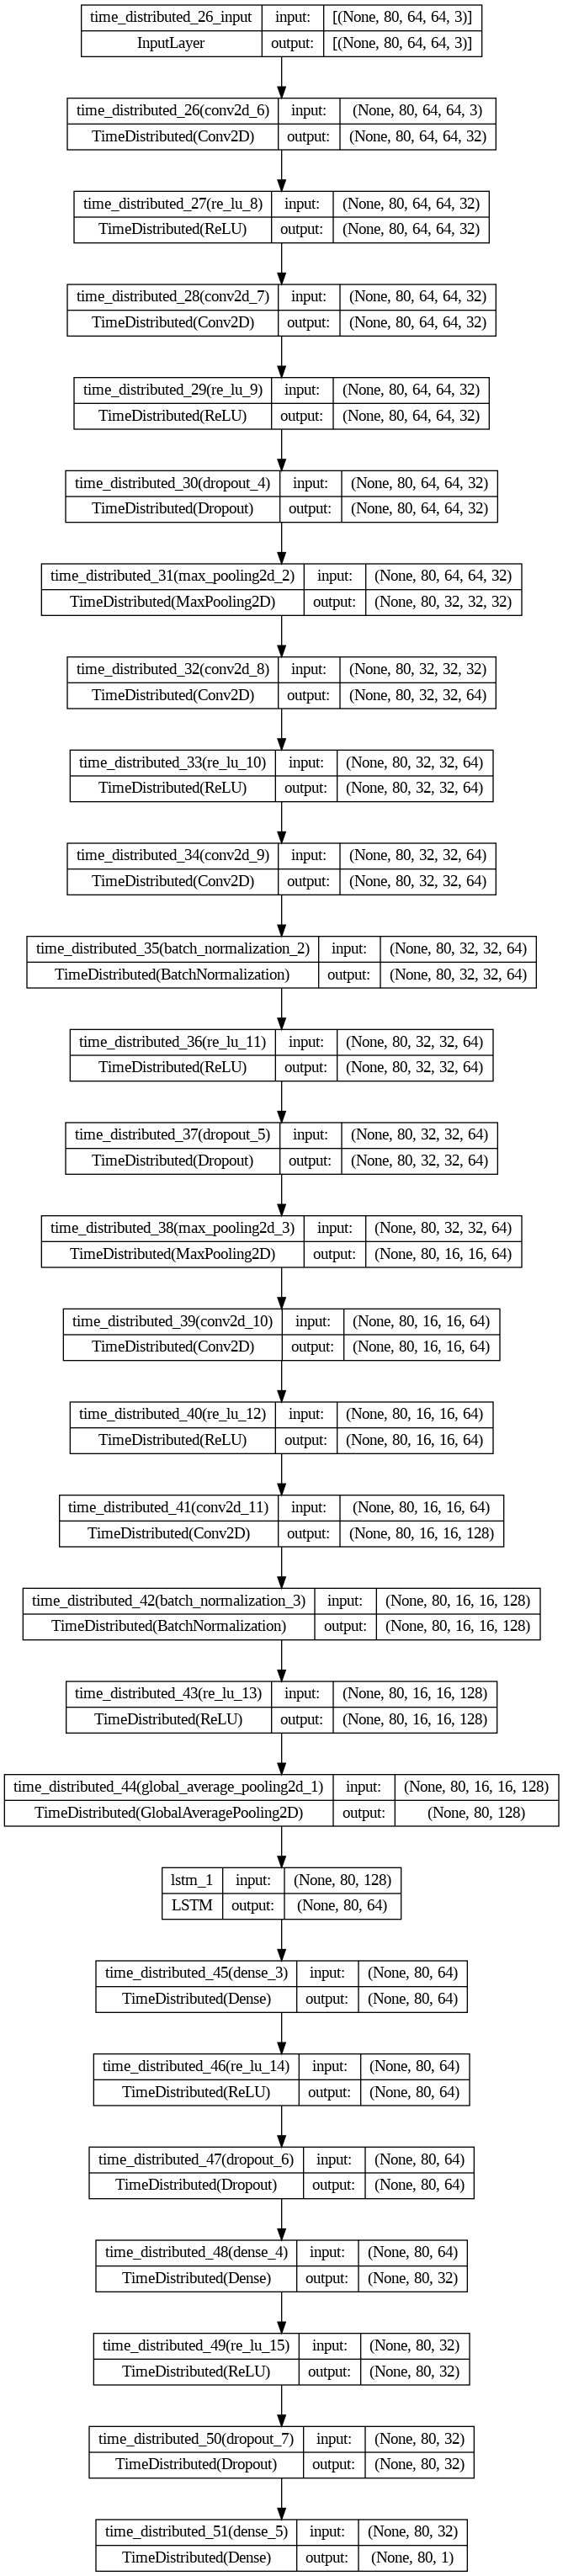

In [ ]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [32]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                   save_weights_only=True, monitor='val_recallAtPrecision', verbose=1, 
#                                                   save_best_only=True, mode='max')
LRCN_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.CategoricalAccuracy(),
                            tf.keras.metrics.RecallAtPrecision(precision=0.9, name='recallAtPrecision'),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   run_eagerly=True)
hist = LRCN_model.fit(x = dataset_train,validation_data=dataset_val,verbose=1, epochs = 10,callbacks = [early_stopping_callback])

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 1.2093 - categorical_accuracy: 0.3536 - recallAtPrecision: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00  

3/3 [==============================] - 474s 203s/step - loss: 1.2093 - categorical_accuracy: 0.3536 - recallAtPrecision: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 1.1948 - categorical_accuracy: 0.3818 - recallAtPrecision: 5.2083e-04 - recall: 0.0031 - precision: 0.6667 

3/3 [==============================] - 156s 44s/step - loss: 1.1948 - categorical_accuracy: 0.3818 - recallAtPrecision: 5.2083e-04 - recall: 0.0031 - precision: 0.6667
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 1.1918 - categorical_accuracy: 0.3677 - recallAtPrecision: 0.0010 - recall: 0.0078 - precision: 0.4412     

3/3 [==============================] - 155s 43s/step - loss: 1.1918 - categorical_accuracy: 0.3677 - recallAtPrecision: 0.0010 - recall: 0.0078 - precision: 0.4412
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 1.1843 - categorical_accuracy: 0.3703 - recallAtPrecision: 0.0016 - recall: 0.0026 - precision: 0.5556 

3/3 [==============================] - 151s 43s/step - loss: 1.1843 - categorical_accuracy: 0.3703 - recallAtPrecision: 0.0016 - recall: 0.0026 - precision: 0.5556
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 1.1826 - categorical_accuracy: 0.3781 - recallAtPrecision: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 

3/3 [==============================] - 161s 47s/step - loss: 1.1826 - categorical_accuracy: 0.3781 - recallAtPrecision: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 1.1743 - categorical_accuracy: 0.3984 - recallAtPrecision: 0.0000e+00 - recall: 5.2083e-04 - precision: 0.5000     

3/3 [==============================] - 162s 46s/step - loss: 1.1743 - categorical_accuracy: 0.3984 - recallAtPrecision: 0.0000e+00 - recall: 5.2083e-04 - precision: 0.5000
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 1.1691 - categorical_accuracy: 0.3969 - recallAtPrecision: 0.0000e+00 - recall: 0.0010 - precision: 0.4000     

3/3 [==============================] - 161s 46s/step - loss: 1.1691 - categorical_accuracy: 0.3969 - recallAtPrecision: 0.0000e+00 - recall: 0.0010 - precision: 0.4000
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 1.1664 - categorical_accuracy: 0.3943 - recallAtPrecision: 0.0000e+00 - recall: 0.0073 - precision: 0.5600 

3/3 [==============================] - 160s 49s/step - loss: 1.1664 - categorical_accuracy: 0.3943 - recallAtPrecision: 0.0000e+00 - recall: 0.0073 - precision: 0.5600
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 1.1525 - categorical_accuracy: 0.4302 - recallAtPrecision: 0.0057 - recall: 0.0135 - precision: 0.7027     

3/3 [==============================] - 163s 49s/step - loss: 1.1525 - categorical_accuracy: 0.4302 - recallAtPrecision: 0.0057 - recall: 0.0135 - precision: 0.7027
Epoch 10/10
3/3 [==============================] - ETA: 0s - loss: 1.1415 - categorical_accuracy: 0.4240 - recallAtPrecision: 0.0031 - recall: 0.0328 - precision: 0.7326 

3/3 [==============================] - 166s 49s/step - loss: 1.1415 - categorical_accuracy: 0.4240 - recallAtPrecision: 0.0031 - recall: 0.0328 - precision: 0.7326


In [48]:
print("Evaluate on test data")
results = LRCN_model.evaluate(filenames_test)
print("test loss, test acc:", results)

# print("Evaluate on train data")
# results = LRCN_model.evaluate(filenames_train)
# print("train loss, trai acc:", results)


Evaluate on test data


UnimplementedError: ignored